In [38]:
import torch
import torchvision
from torch import nn, optim
import numpy as np

In [2]:
tr = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

cifar10_data = torchvision.datasets.CIFAR10("cifar10_train_data", download=True, transform=tr)
test_data = torchvision.datasets.CIFAR10("cifar10_test_data", download=True, train=False, transform=tr)

dataloader = torch.utils.data.DataLoader(cifar10_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        
        self.linear1 = nn.Linear(4096, 256)
        self.linear2 = nn.Linear(256, 10)
        
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,X):
        n = X.size(0)
        
        X = self.relu(self.conv1(X))
        X = self.relu(self.conv2(X))
        X = self.pool(X)
        
        X = self.relu(self.conv3(X))
        X = self.relu(self.conv4(X))
        X = self.pool(X)
        
        X = X.view(n,-1)
        
        X = self.relu(self.linear1(X))
        X = self.softmax(self.linear2(X))
        return X
        

In [ ]:
model = CNN1()
loss_fn = nn.CrossEntropyLoss()
params = model.parameters()
optimizer = optim.SGD(params = params,lr=.01, momentum=0.9)

n_epochs = 15
n_iterations = 0

for e in range(n_epochs):
    running_loss = 0
    for i,(images,labels) in enumerate(dataloader):
        #forward pass
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        
        #backward pass
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(dataloader)))

In [27]:
correct_count, all_count = 0, 0

incorrect = [[]]
y_predicted = []
y_actual = []

for images,labels in testloader:
    for i in range(len(labels)):
        img = images[i].view(1, 3, 32, 32)
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        
        y_predicted.append(pred_label)
        y_actual.append(true_label)
        
        if(true_label == pred_label):
            correct_count += 1
        else:
            incorrect.append([images[i],pred_label,true_label])
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.6897


In [14]:
torch.save(model.state_dict(), "cifarmodel.pt")

In [31]:
print(len(incorrect))
print(len(y_predicted))
print(len(y_actual))

3104
10000
10000


1. Guess: airplane / Actual: frog
2. Guess: deer / Actual: cat
3. Guess: dog / Actual: cat
4. Guess: truck / Actual: automobile
5. Guess: cat / Actual: deer
6. Guess: cat / Actual: dog
7. Guess: ship / Actual: truck
8. Guess: deer / Actual: dog
9. Guess: automobile / Actual: truck
10. Guess: airplane / Actual: ship
11. Guess: horse / Actual: deer
12. Guess: ship / Actual: cat
13. Guess: bird / Actual: deer
14. Guess: horse / Actual: airplane
15. Guess: frog / Actual: deer


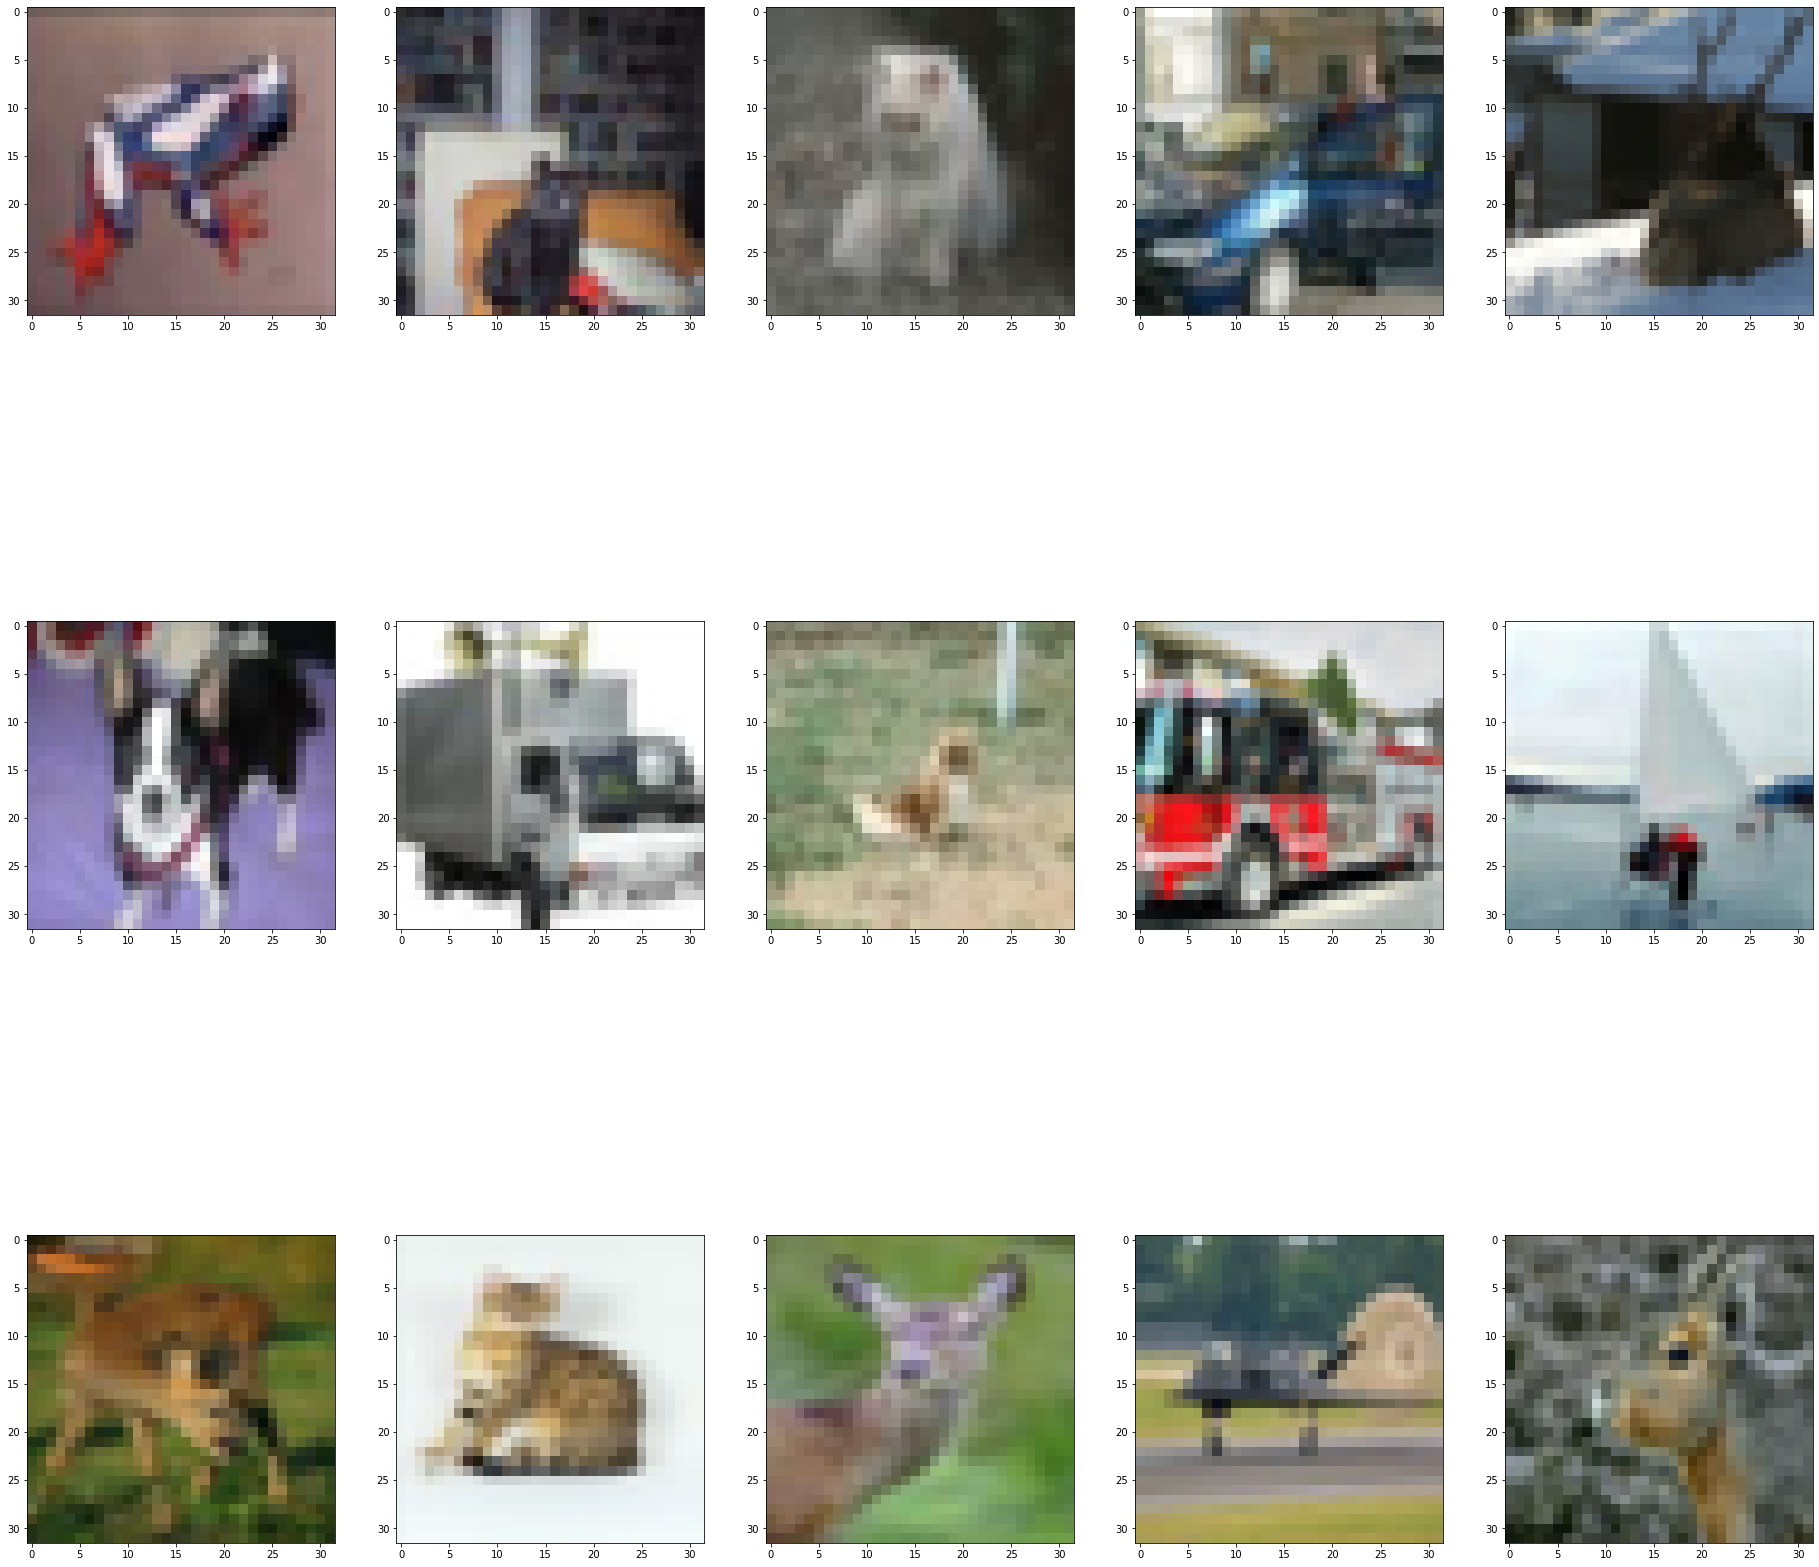

In [21]:
incorrect = [x for x in incorrect if x != []]

import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 5, figsize=(32,32))

for i,im in enumerate(axes.flat):
    im.imshow(incorrect[i][0].permute(1,2,0))
    
for k in range(15):
    print(str(k+1)+". Guess: "+num_to_class(incorrect[k][1])+ " / Actual: "+num_to_class(incorrect[k][2]))

In [9]:
model = CNN1()
model.load_state_dict(torch.load("cifarmodel.pt"))
model.eval()

CNN1(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4096, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax()
)

2464. Guess: ship / Actual: airplane


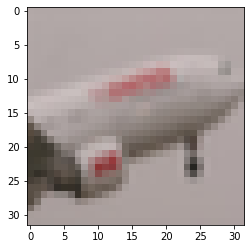

In [25]:
import random
index = random.randrange(0,len(incorrect))
plt.imshow(incorrect[index][0].permute(1,2,0))
print(str(index) + ". Guess: "+num_to_class(incorrect[index][1])+" / Actual: "+num_to_class(incorrect[index][2]))

In [26]:
def num_to_class(n):
    switch = {
        0 : "airplane",
        1 : "automobile",
        2 : "bird",
        3 : "cat",
        4 : "deer",
        5 : "dog",
        6 : "frog",
        7 : "horse",
        8 : "ship",
        9 : "truck"
    }
    return switch.get(n)
        

In [36]:
import sklearn.metrics
conf_mx = sklearn.metrics.confusion_matrix(y_actual,y_predicted)
conf_mx

array([[736,  15,  73,  19,  13,   9,  10,  15,  83,  27],
       [ 21, 795,  13,   8,   5,   6,  12,   5,  50,  85],
       [ 79,   6, 622,  45,  81,  52,  47,  31,  26,  11],
       [ 23,  15, 118, 456,  61, 137,  93,  46,  28,  23],
       [ 18,   5, 129,  50, 606,  24,  51,  95,  16,   6],
       [ 18,   5,  79, 163,  48, 545,  48,  54,  27,  13],
       [  7,  11,  69,  42,  40,  31, 764,  11,  14,  11],
       [ 23,   4,  44,  36,  58,  45,  12, 752,   4,  22],
       [ 53,  23,  15,   8,   6,   6,   4,   4, 862,  19],
       [ 37,  92,  15,  12,   9,   8,   8,  13,  47, 759]])

In [54]:
mod_mx = conf_mx
for k in range(10):
    mod_mx[k][k] = 0
    var = np.where(mod_mx[k] == np.amax(mod_mx[k]))[0][0]
    print(num_to_class(var) + " is most commonly mistaken to be " + num_to_class(k))
    
    

ship is most commonly mistaken to be airplane
truck is most commonly mistaken to be automobile
deer is most commonly mistaken to be bird
dog is most commonly mistaken to be cat
bird is most commonly mistaken to be deer
cat is most commonly mistaken to be dog
bird is most commonly mistaken to be frog
deer is most commonly mistaken to be horse
airplane is most commonly mistaken to be ship
automobile is most commonly mistaken to be truck
